In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.optimize import curve_fit

In [2]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw1 = Table.read('../analysis_products/galah_dr4_allspec_not_validated.fits')
galah_dr4_raw2 = Table.read('../analysis_products/galah_dr4_allspec_not_validated.fits')

In [3]:
dr60 = Table.read('../auxiliary_information/dr6.0.fits')

In [4]:
galah_dr4_raw1 = join(galah_dr4_raw1, dr60, keys='sobject_id')
galah_dr4_raw2 = join(galah_dr4_raw2, dr60, keys='sobject_id')

In [5]:
# Join them with the tmass_id keyword
joined = join(galah_dr4_raw1, galah_dr4_raw2, keys='tmass_id')

In [6]:
duplicate = np.array([x['sobject_id_1'] == x['sobject_id_2'] for x in joined])

In [7]:
repeat = joined[~duplicate]

In [8]:
len(repeat)

23390

In [9]:
def sigma_function(xdata, c1, c2, c3, c4, c5, c6):
    teff, logg, fe_h, snr = xdata
    return np.exp(c1 + c2*teff + c3*logg + c4*fe_h + c5*snr)+c6

In [10]:
ranges = dict()
ranges['teff'] = 200
ranges['logg'] = 0.5
ranges['fe_h'] = 0.2
ranges['vmic'] = 0.2
ranges['vsini'] = 2

precision_labels = ['teff','logg','fe_h','vmic','vsini']
for element in [
        'Li','C','N','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
        'Rb','Sr','Y','Zr','Mo','Ru',
        'Ba','La','Ce','Nd','Sm','Eu'
]:
    precision_labels.append(element.lower()+'_fe')
    ranges[element.lower()+'_fe'] = 0.2

In [11]:
repeat_data = Table()

for label in precision_labels:
    repeat_data[label+'_mean'] = np.mean([repeat[label+'_1'],repeat[label+'_2']],axis=0)
    repeat_data[label+'_sigma'] = np.abs(repeat[label+'_1']-repeat[label+'_2'])/np.sqrt(2) #np.std([repeat[label+'_1'],repeat[label+'_2']],axis=0)
    repeat_data[label+'_cov'] = np.mean([repeat['cov_e_'+label+'_1'],repeat['cov_e_'+label+'_2']],axis=0)
repeat_data['snr_mean'] = np.mean([repeat['snr_1'][:,1],repeat['snr_2'][:,1]],axis=0)
repeat_data['snr_sigma'] = np.std([repeat['snr_1'][:,1],repeat['snr_2'][:,1]],axis=0)

In [12]:
entries = []
sigmas  = dict()
for label in precision_labels:
    sigmas[label] = []
teffs   = []
loggs   = []
fe_hs   = []
snrs    = []

teff_bin_size = 250
logg_bin_size = 0.5
fe_h_bin_size = 0.5
snr_bin_size  = 10

teff_bins = np.arange(3250,8001,teff_bin_size)
logg_bins = np.arange(-1,6,logg_bin_size)
fe_h_bins = np.arange(-4,1,fe_h_bin_size)
snr_bins  = np.arange(0.5*snr_bin_size,200,snr_bin_size)

for teff in teff_bins:
    for logg in logg_bins:
        for fe_h in fe_h_bins:
            for snr in snr_bins:
                in_bin = (
                    (repeat_data['teff_mean'] > teff - 0.5*teff_bin_size) &
                    (repeat_data['teff_mean'] <= teff + 0.5*teff_bin_size) &
                    (repeat_data['logg_mean'] > logg - 0.5*logg_bin_size) &
                    (repeat_data['logg_mean'] <= logg + 0.5*logg_bin_size) &
                    (repeat_data['fe_h_mean'] > fe_h - 0.5*fe_h_bin_size) &
                    (repeat_data['fe_h_mean'] <= fe_h + 0.5*fe_h_bin_size) &
                    (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                    (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
                )
                nr_in_bin = len(repeat_data['teff_mean'][in_bin])
                if nr_in_bin > 5:
                    entries.append(nr_in_bin)
                    for label in precision_labels:
                        sigmas[label].append(np.median(repeat_data[label+'_sigma'][in_bin]))
                    teffs.append(teff)
                    loggs.append(logg)
                    fe_hs.append(fe_h)
                    snrs.append(snr)
entries = np.array(entries)
for label in precision_labels:
    sigmas[label] = np.array(sigmas[label])
teffs = np.array(teffs)
loggs = np.array(loggs)
fe_hs = np.array(fe_hs)
snrs = np.array(snrs)

/Users/svenbuder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/var/folders/fk/njpttmdx5yb1y0hp7br9z1cc0000gn/T/ipykernel_93366/2204888312.py:45: UserWarning: Warning: converting a masked element to nan.
  sigmas[label] = np.array(sigmas[label])


In [13]:
np.unique(snrs)

array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145., 155., 165.])

In [14]:
for label in precision_labels:
    rc_example = (teffs == 5000) & (loggs == 2.5) & (fe_hs == 0.00)
    print(snrs[rc_example])
    print(sigmas[label][rc_example])

[25. 35. 45. 65. 75. 85.]
[196.04796   57.273926  41.955635  41.12527   13.098048  29.98402 ]
[25. 35. 45. 65. 75. 85.]
[0.33940622 0.15679033 0.19475427 0.16212973 0.01903217 0.06537558]
[25. 35. 45. 65. 75. 85.]
[0.24921873 0.06301348 0.04770559 0.04128981 0.01981941 0.01009859]
[25. 35. 45. 65. 75. 85.]
[0.0693977  0.04221201 0.08877121 0.01724379 0.01253582 0.01487236]
[25. 35. 45. 65. 75. 85.]
[2.358812   0.3507717  1.105445   0.31038392 0.5534212  0.7435576 ]
[25. 35. 45. 65. 75. 85.]
[0.15813074 0.05238963 0.06224011 0.0378186  0.0127683  0.06565291]
[25. 35. 45. 65. 75. 85.]
[0.12804668 0.00982888 0.0348571  0.03342354 0.00747691 0.02077721]
[25. 35. 45. 65. 75. 85.]
[0.10713208 0.03302545 0.03909681 0.02231219 0.03429477 0.00365197]
[25. 35. 45. 65. 75. 85.]
[0.107955   0.08977747 0.0622564  0.04005897 0.03828167 0.05639873]
[25. 35. 45. 65. 75. 85.]
[0.15079382 0.04528921 0.05785109 0.05712023 0.02565525 0.02928948]
[25. 35. 45. 65. 75. 85.]
[0.05215891 0.06326711 0.05135783 

In [15]:
def sigma_snr_function(xdata, c1, c2, c3, c4, c5):
    snr, teff, logg, fe_h = xdata
    return c1 + c2 * (teff-5000) + c3 * (logg-2.5) + c4 * fe_h + c5 * (snr.clip(min=0, max=200)-50)

def fit_precision_function(label):
    
    useful = np.isfinite(repeat[label+'_1']) & np.isfinite(repeat[label+'_2'])
    useful_sigmas = np.isfinite(sigmas[label])
        
    popt, pcov = curve_fit(
            sigma_snr_function,
            xdata=np.array([
                snrs[useful_sigmas],
                teffs[useful_sigmas],
                loggs[useful_sigmas],
                fe_hs[useful_sigmas]
            ]),
            ydata=np.log(np.array(sigmas[label])[useful_sigmas]),
            p0 = [0,0,0,0,0]
        )

#     predicted_sigma = np.exp(sigma_snr_function([snrs[useful_sigmas],teffs[useful_sigmas],loggs[useful_sigmas],fe_hs[useful_sigmas]],*popt))

    print(label,np.exp(popt[0]),popt)

#     f, gs = plt.subplots(1,3,sharey=True,figsize=(15,5))

#     corner.hist2d(
#         repeat_data['snr_mean'][useful],
#         repeat_data[label+'_sigma'][useful],
#         bins=50,
#         range=[(0,200),(0,ranges[label])],
#         ax=gs[0]
#     )

#     corner.hist2d(
#         snrs[useful_sigmas],
#         predicted_sigma,
#         bins=50,
#         range=[(0,200),(0,ranges[label])],
#         ax=gs[1]
#     )
#     corner.hist2d(
#         repeat_data['snr_mean'][useful],
#         repeat_data[label+'_cov'][useful],
#         bins=50,
#         range=[(0,200),(0,ranges[label])],
#         ax=gs[2]
#     )

#     bins_size = 20
#     for bins in np.arange(0,200,bins_size):
#         in_bins = (repeat_data['snr_mean'][useful] > bins) & (repeat_data['snr_mean'][useful] <= bins + bins_size)
#         gs[0].scatter(
#             bins+bins_size/2.,
#             np.median(repeat_data[label+'_sigma'][useful][in_bins]),
#             c='r'
#         )
#         gs[1].scatter(
#             bins+bins_size/2.,
#             np.median(repeat_data[label+'_sigma'][useful][in_bins]),
#             c='r'
#         )
#         gs[2].scatter(
#             bins+bins_size/2.,
#             np.median(repeat_data[label+'_sigma'][useful][in_bins]),
#             c='r'
#         )
    return(popt)

In [16]:
coeffs = dict()

for label in precision_labels:
    coeffs[label] = fit_precision_function(label)

teff 25.290005231297666 [ 3.23040927e+00 -9.29344731e-05  2.37818939e-01 -2.00253454e-01
 -1.39261451e-02]
logg 0.09525247826923416 [-2.35122425e+00  1.12787030e-04 -1.82753218e-01 -1.89885927e-01
 -1.46847558e-02]
fe_h 0.030360257518007326 [-3.49462084e+00 -9.55991064e-05  9.72591075e-02 -2.90039616e-01
 -1.60879260e-02]
vmic 0.049741396996029454 [-3.00091776e+00  5.67435675e-05  2.91690552e-01 -4.98016194e-01
 -1.58173315e-02]
vsini 0.64165680779814 [-4.43701686e-01 -2.24960029e-04  1.69204402e-01  2.67831831e-03
 -1.05275853e-02]
li_fe 0.1202995422361818 [-2.11777046e+00  1.86368286e-04  1.15525142e-01 -5.05140452e-01
 -1.59389820e-02]
c_fe 0.06787968314636494 [-2.69001851e+00 -2.67472525e-04 -4.81178567e-03 -3.99076912e-01
 -1.40602916e-02]
n_fe 0.054730019910941334 [-2.90534291e+00 -1.03178010e-03  3.62058942e-01 -7.20655605e-01
 -1.27073077e-02]
o_fe 0.12401963741545512 [-2.08731536e+00 -5.24995885e-04  7.58045394e-02 -2.39032065e-01
 -1.49312264e-02]
na_fe 0.050148649380284724 [

/Users/svenbuder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/svenbuder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


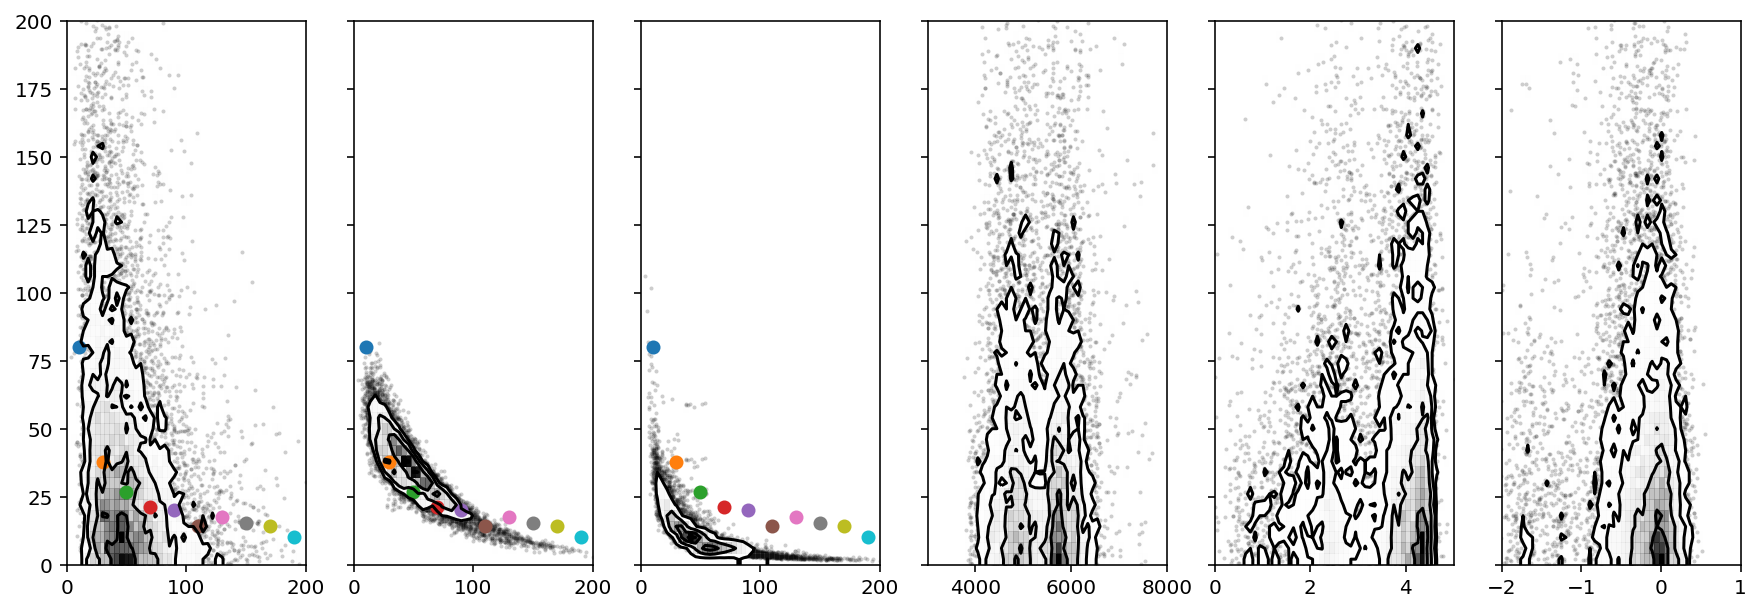

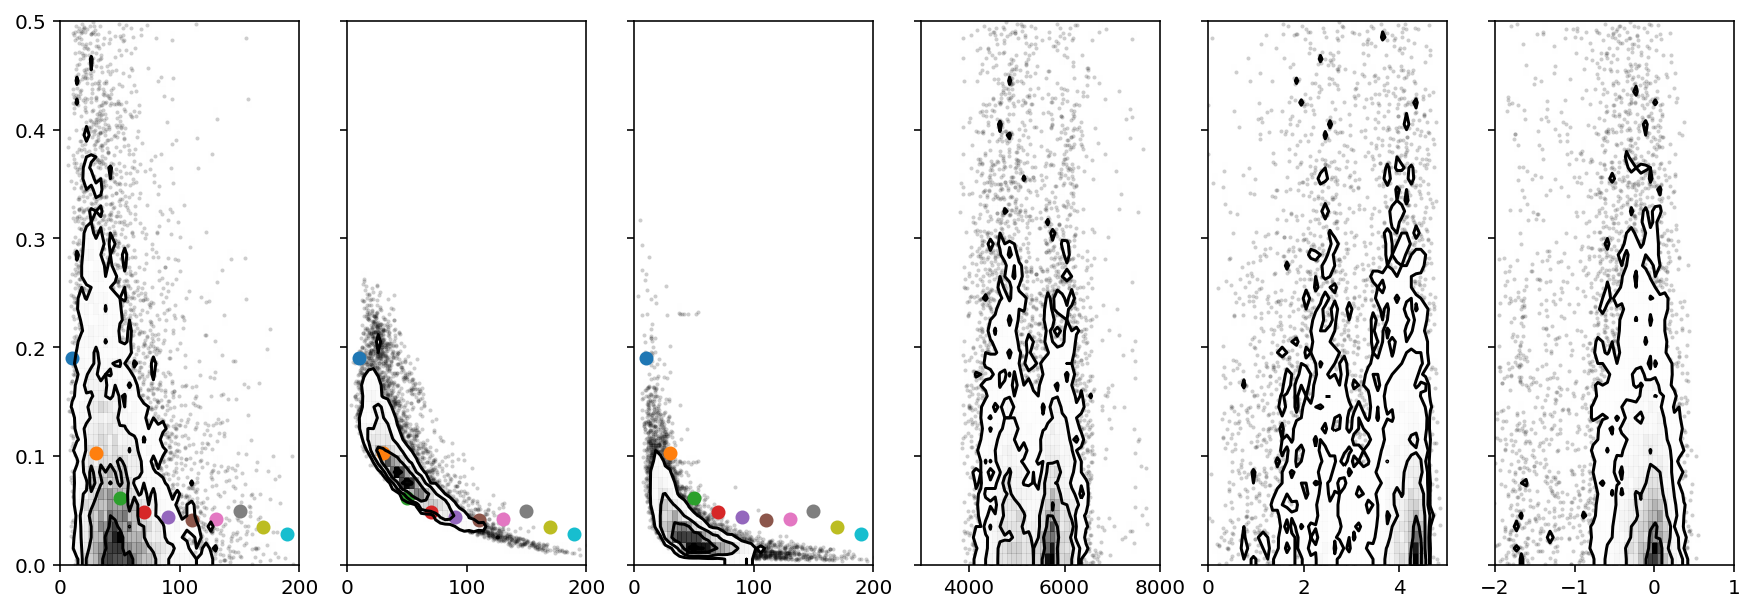

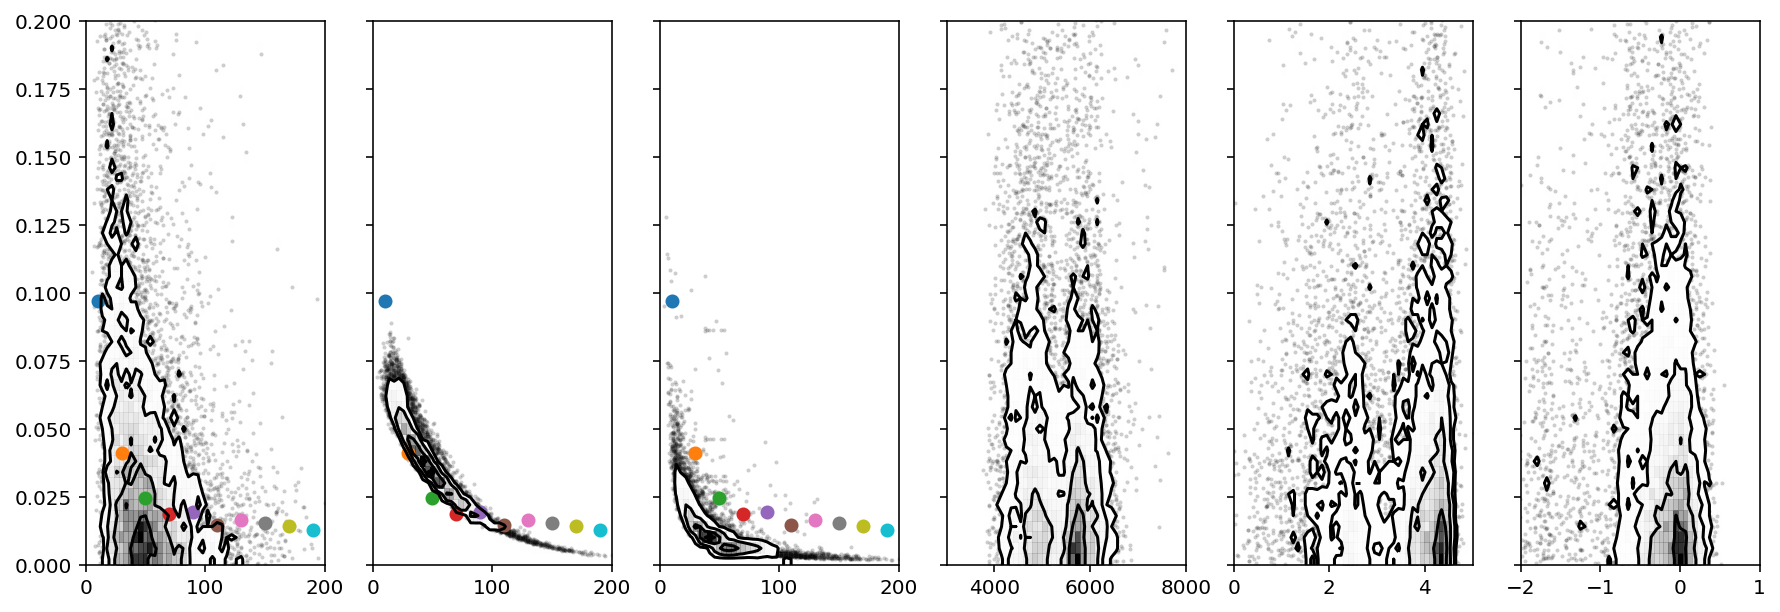

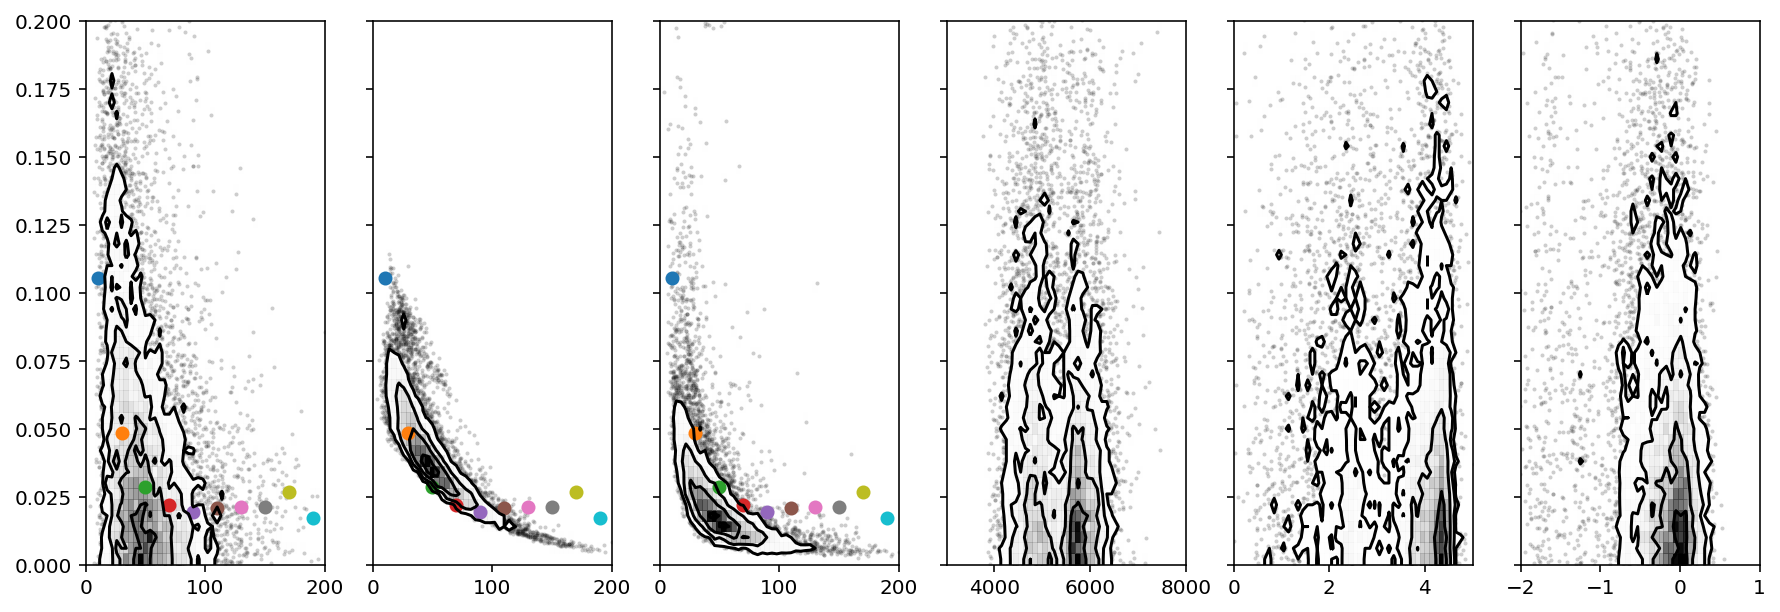

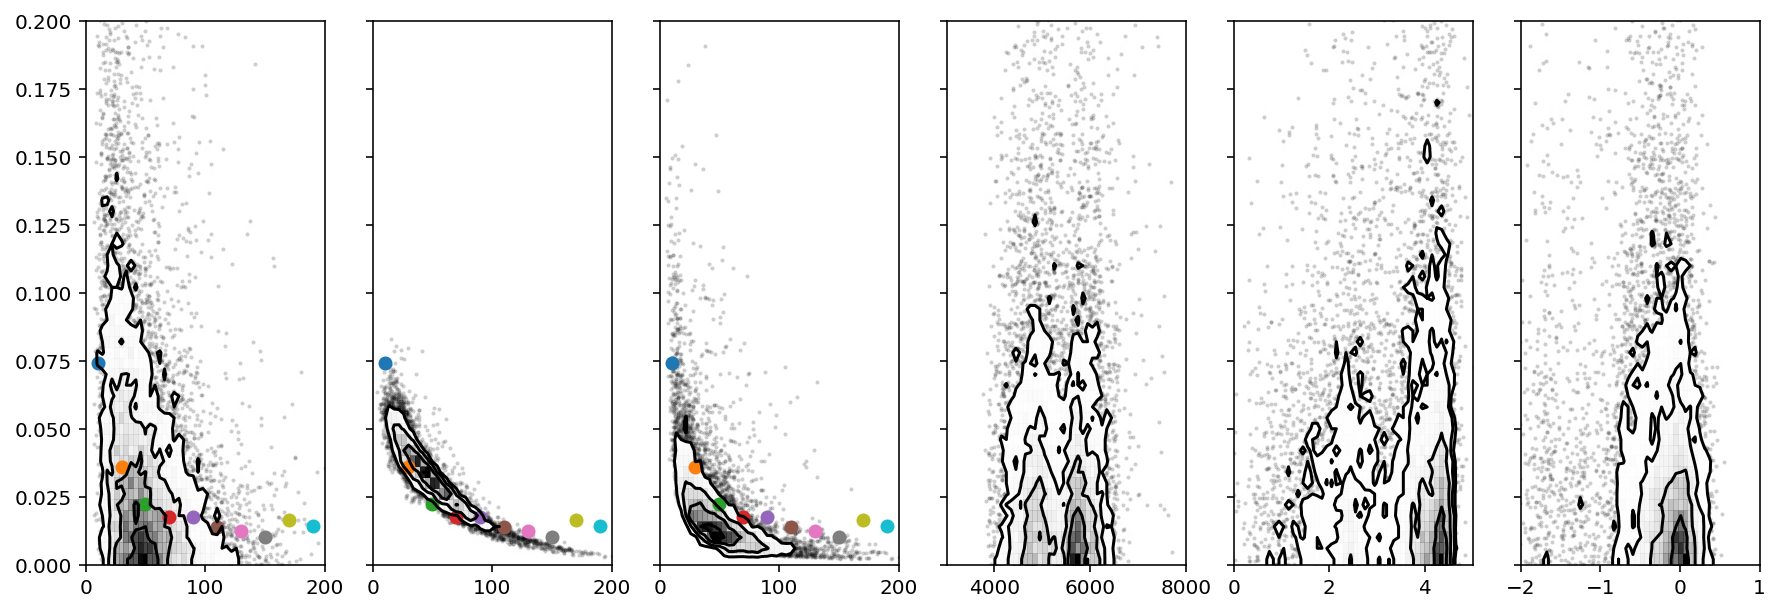

In [17]:
for label in ['teff','logg','fe_h','mg_fe','ti_fe']:
    
    useful = np.isfinite(repeat[label+'_1']) & np.isfinite(repeat[label+'_2'])

    predicted_sigma = np.exp(sigma_snr_function(np.array([repeat_data['snr_mean'][useful],repeat_data['teff_mean'][useful],repeat_data['logg_mean'][useful],repeat_data['fe_h_mean'][useful]]),*coeffs[label]))
    
    f, gs = plt.subplots(1,6,sharey=True,figsize=(15,5))
    
    corner.hist2d(
        repeat_data['snr_mean'][useful],
        repeat_data[label+'_sigma'][useful],
        bins=50,
        range=[(0,200),(0,ranges[label])],
        ax=gs[0]
    )
    corner.hist2d(
        repeat_data['snr_mean'][useful],
        predicted_sigma,
        bins=50,
        range=[(0,200),(0,ranges[label])],
        ax=gs[1]
    )
    corner.hist2d(
        repeat_data['snr_mean'][useful],
        repeat_data[label+'_cov'][useful],
        bins=50,
        range=[(0,200),(0,ranges[label])],
        ax=gs[2]
    )
    corner.hist2d(
        repeat_data['teff_mean'][useful],
        repeat_data[label+'_sigma'][useful],
        bins=50,
        range=[(3000,8000),(0,ranges[label])],
        ax=gs[3]
    )
    corner.hist2d(
        repeat_data['logg_mean'][useful],
        repeat_data[label+'_sigma'][useful],
        bins=50,
        range=[(0,5),(0,ranges[label])],
        ax=gs[4]
    )
    corner.hist2d(
        repeat_data['fe_h_mean'][useful],
        repeat_data[label+'_sigma'][useful],
        bins=50,
        range=[(-2,1),(0,ranges[label])],
        ax=gs[5]
    )

    bins_size = 20
    for bins in np.arange(0,200,bins_size):
        in_bins = (repeat_data['snr_mean'][useful] > bins) & (repeat_data['snr_mean'][useful] <= bins + bins_size)
        gs[0].scatter(
            bins+bins_size/2.,
            np.median(repeat_data[label+'_sigma'][useful][in_bins])
        )
        gs[1].scatter(
            bins+bins_size/2.,
            np.median(repeat_data[label+'_sigma'][useful][in_bins])
        )
        gs[2].scatter(
            bins+bins_size/2.,
            np.median(repeat_data[label+'_sigma'][useful][in_bins])
        )